#### ARIMA
###### (AutoRegressive Integrated Moving Average) is a statistical model used for time series forecasting. It is based on the assumption that the time series is stationary and that the relationship between the observations and the lagged observations can be modeled using a linear combination of autoregression, differencing, and moving average terms.

##### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline

In [2]:
# # Define the stock symbol
# stock_symbol = 'SBIN.NS'

In [3]:
# # Specify the date range
# start_date = '2021-01-01'
# end_date = '2022-12-31'

##### Importing the dataset of SBI.NS

In [4]:
stock_data = pd.read_csv('SBIN.NS.csv',usecols=['Date','Close'])

In [5]:
# # Download the historical stock prices
# stock_data = yf.download(stock_symbol, start=start_date, end=end_date,interval='1d')

In [6]:
stock_data.head()

,Date,Close
0,2022-01-10,503.649994
1,2022-01-11,505.950012
2,2022-01-12,510.250000
3,2022-01-13,511.350006
4,2022-01-14,508.350006


In [7]:
stock_data.columns

Index(['Date', 'Close'], dtype='object')

In [8]:
stock_data.rename({'Date':'ds','Close':'y'},axis = 1, inplace=True)

In [9]:
# stock_data['Date'] = stock_data['Date'].dt.accessor ('%m-%d-%Y')

In [10]:
stock_data

,ds,y
0,2022-01-10,503.649994
1,2022-01-11,505.950012
2,2022-01-12,510.250000
3,2022-01-13,511.350006
4,2022-01-14,508.350006
...,...,...
245,2023-01-04,605.200012
246,2023-01-05,605.099976
247,2023-01-06,600.650024
248,2023-01-09,607.700012


In [11]:
# Updating the header
stock_data.columns=["ds","y"]
stock_data.head()
stock_data.describe()
stock_data.set_index('ds',inplace=True)

<AxesSubplot:xlabel='ds'>

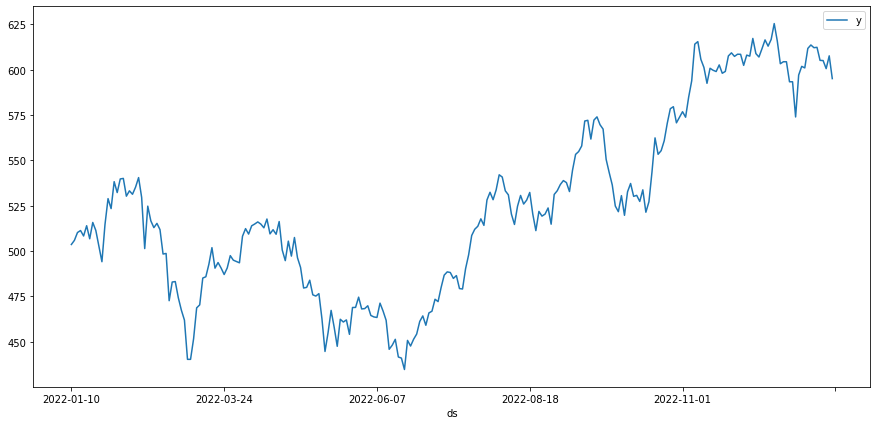

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
stock_data.plot()

###### Obseervation: The above graph shows a trend that there is a time when y (Close) are high and vice versa. That means we can see data is following seasonality. For ARIMA first thing is to identify whether data is stationary or non – stationary. If the data is found non-stationary then we will try to make them stationary then we will process further.

##### To check the dataset is stationary or not we use adfuller

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
test_result=adfuller(stock_data['y'])

##### To identify the nature of data, we will use Null Hypothesis.

###### H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt.

###### H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0.

##### Ho: It is non-stationary
###### H1: It is stationary

###### For the above scenario we will be considering the null hypothesis that data is not stationary and the alternate hypothesis that data is stationary.

In [15]:
def adfuller_test(close):
    result=adfuller(close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(stock_data['y'])

ADF Test Statistic : -0.9824340043422017
p-value : 0.7596170588233042
#Lags Used : 0
Number of Observations : 249
weak evidence against null hypothesis,indicating it is non-stationary 


###### Here the P-value is 0.7596 which is greater than 0.05, which means data is accepting the null hypothesis, which means data is non-stationary.

##### Checking the first difference and seasonal difference:

In [16]:
stock_data['Close First Difference'] = stock_data['y'] - stock_data['y'].shift(1)
stock_data['Seasonal First Difference']=stock_data['y']-stock_data['y'].shift(12)
stock_data.head()

,y,Close First Difference,Seasonal First Difference
ds,,,
2022-01-10,503.649994,NaN,NaN
2022-01-11,505.950012,2.300018,NaN
2022-01-12,510.250000,4.299988,NaN
2022-01-13,511.350006,1.100006,NaN
2022-01-14,508.350006,-3.000000,NaN


In [17]:
# Again testing if data is stationary
adfuller_test(stock_data['Seasonal First Difference'].dropna())

ADF Test Statistic : -3.181851398653528
p-value : 0.021059519867758968
#Lags Used : 12
Number of Observations : 225
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


###### The P-value is -3.18, that means null hypothesis gets rejected. So data is stationary.

<AxesSubplot:xlabel='ds'>

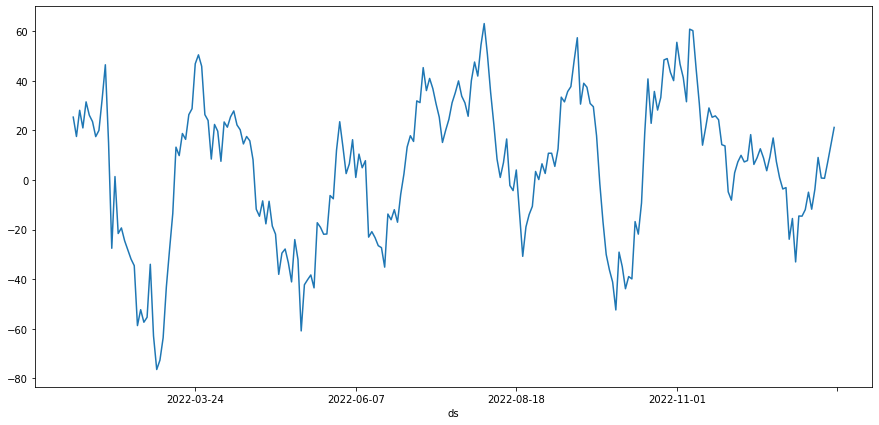

In [18]:
stock_data['Seasonal First Difference'].plot()

###### Plotting Auto-Correlation Graph to get a better understanding

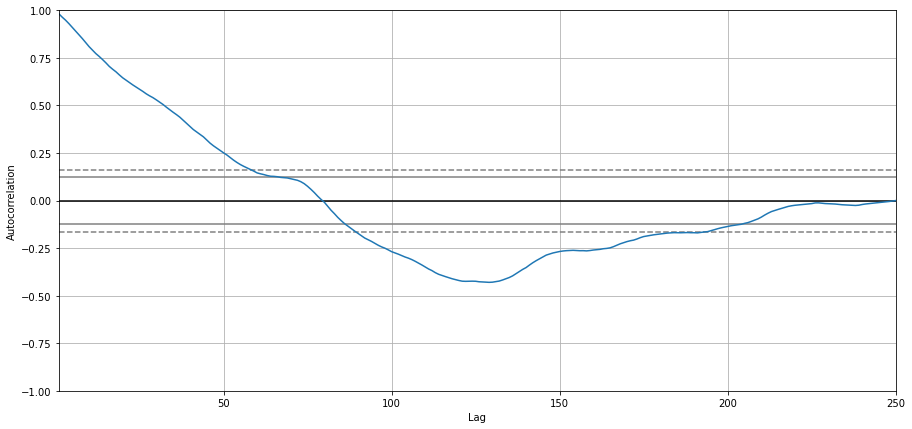

In [19]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(stock_data['y'])
plt.show()

C:\Users\Shobhandeb\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


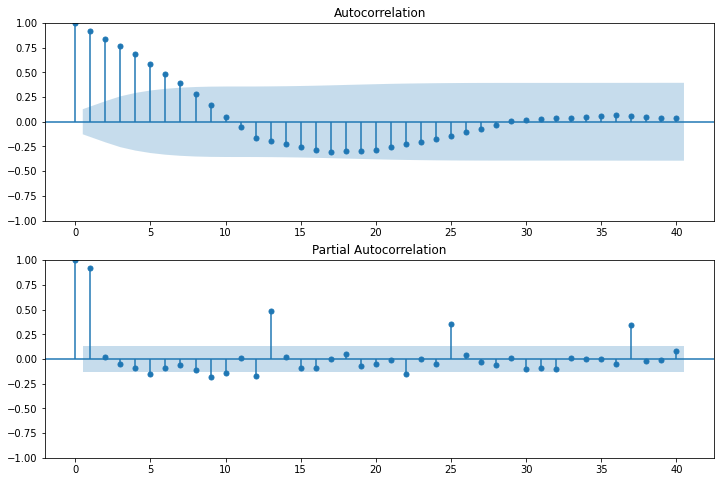

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock_data['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock_data['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

##### Building the ARIMA model: Once the order of differencing, autoregression, and moving average have been identified, the ARIMA model can be built using the statsmodels.tsa.arima_model.ARIMA() function in python.

In [21]:
# For non-seasonal data
#p=1, d=1, q=0 or 1

from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(stock_data['y'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

C:\Users\Shobhandeb\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Shobhandeb\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Shobhandeb\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -882.110
Date:                Thu, 26 Jan 2023   AIC                           1770.221
Time:                        23:03:31   BIC                           1780.773
Sample:                             0   HQIC                          1774.468
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0824      0.849      0.097      0.923      -1.582       1.747
ma.L1         -0.1534      0.840     -0.183      0.855      -1.800       1.493
sigma2        69.9181      5.615     12.451      0.000      58.912      80.924
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.09
Prob(Q):                              0.98   Prob(JB):                         0.13
Heteroskedasticity (H):               0.77   Skew:                            -0.16
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='ds'>

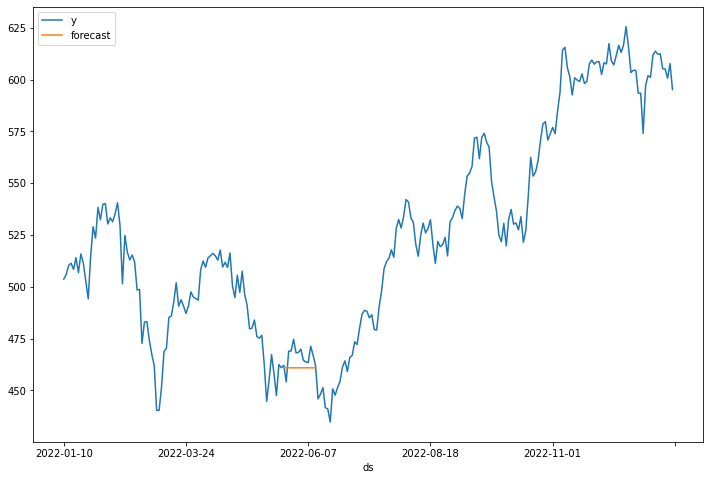

In [22]:
stock_data['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
stock_data[['y','forecast']].plot(figsize=(12,8))

C:\Users\Shobhandeb\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Shobhandeb\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='ds'>

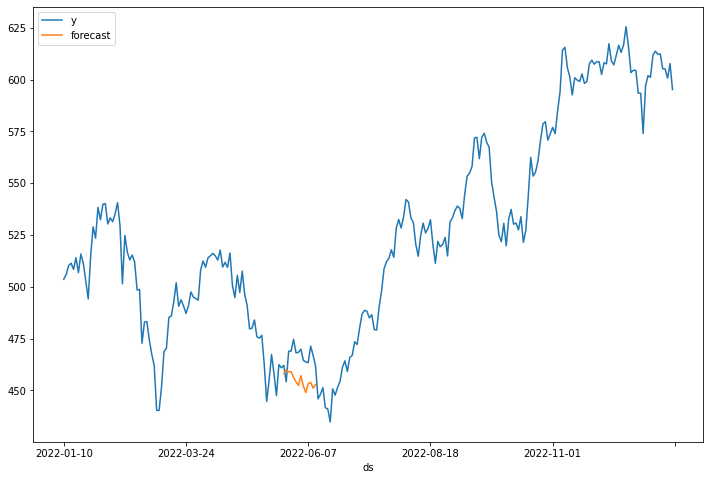

In [23]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(stock_data['y'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
stock_data['forecast']=results.predict(start=90,end=103,dynamic=True)
stock_data[['y','forecast']].plot(figsize=(12,8))

<AxesSubplot:>

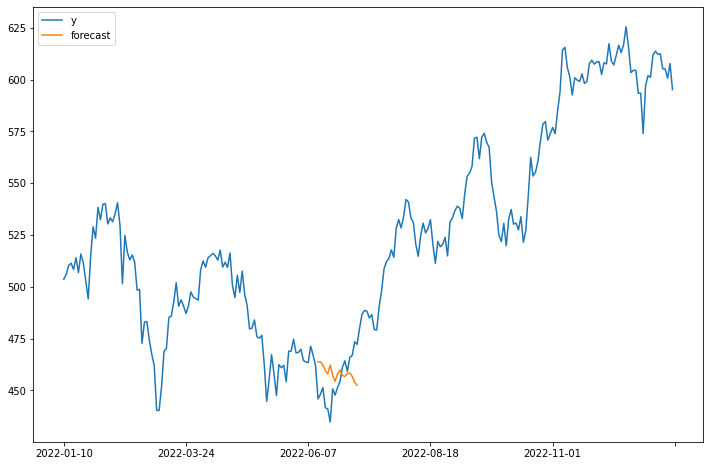

In [24]:
from pandas.tseries.offsets import DateOffset
future_dates=[stock_data.index[-1]]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=stock_data.columns)

future_datest_df.tail()

future_df=pd.concat([stock_data,future_datest_df])

future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)
future_df[['y', 'forecast']].plot(figsize=(12, 8))

In [57]:
stock_sbi = pd.read_csv('SBIN.NS.csv',usecols=['Date','Adj Close'])
stock_sbi.rename({'Date':'ds','Adj Close':'y'},axis = 1, inplace=True)

In [58]:
from prophet import Prophet
model = Prophet()
model.fit(stock_sbi)

23:59:27 - cmdstanpy - INFO - Chain [1] start processing
23:59:27 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
stock_sbi.columns

Index(['ds', 'y'], dtype='object')

In [60]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
610,2024-01-06
611,2024-01-07
612,2024-01-08
613,2024-01-09
614,2024-01-10


In [61]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
610,2024-01-06,858.037202,749.650281,963.528945
611,2024-01-07,858.711909,749.189696,964.199465
612,2024-01-08,866.713437,756.400822,977.861553
613,2024-01-09,868.965225,759.640880,977.083047
614,2024-01-10,871.047535,756.600074,980.870338


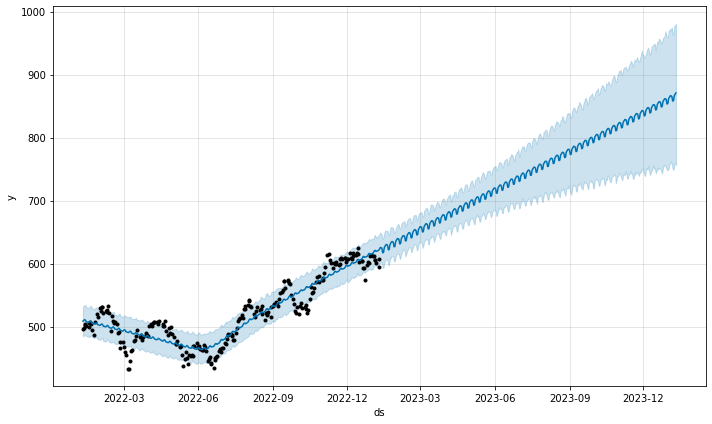

In [62]:
forecast_plot = model.plot(forecast)

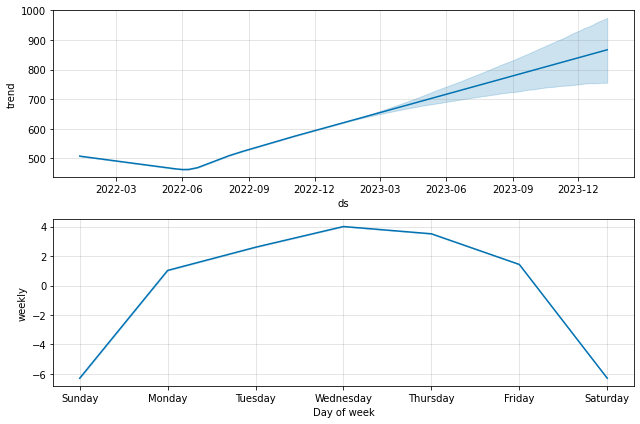

In [63]:
forecast_components = model.plot_components(forecast)

In [64]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

In [65]:
plot_components_plotly(model, forecast)

In [66]:
stock_sbi['cap'] = 8.5

In [67]:
m = Prophet(growth='logistic')
m.fit(stock_sbi)

23:59:33 - cmdstanpy - INFO - Chain [1] start processing
23:59:33 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
stock_sbi.columns

Index(['ds', 'y', 'cap'], dtype='object')

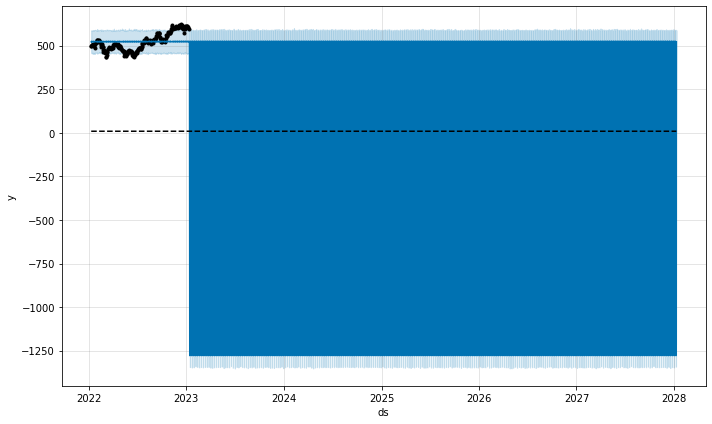

In [69]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
fig = m.plot(fcst)

23:59:40 - cmdstanpy - INFO - Chain [1] start processing
23:59:41 - cmdstanpy - INFO - Chain [1] done processing


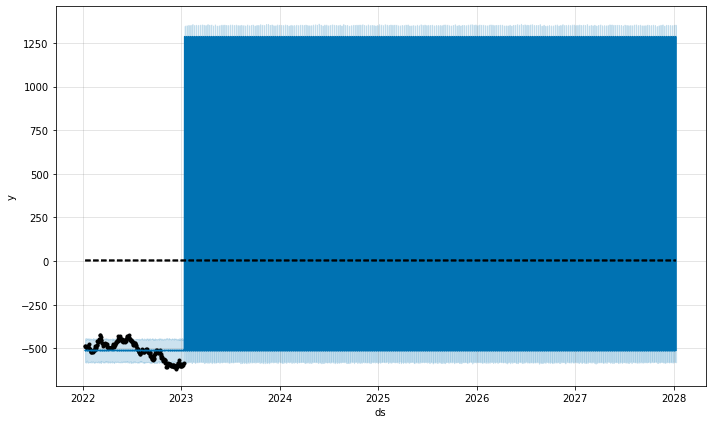

In [70]:
stock_sbi['y'] = 10 - stock_sbi['y']
stock_sbi['cap'] = 6
stock_sbi['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5
m = Prophet(growth='logistic')
m.fit(stock_sbi)
fcst = m.predict(future)
fig = m.plot(fcst)